Date created: July 13, 2022

---

## Project 2: Flow Over a Flat Plate
**Contributors:** Mason Friedberg, Brian Tan, Tyler Reiser      
**Summary:** Modeling the flow over a flat plate.  
       
---

#### Physics

...*write about physics here*...


#### Finding the coupled system
We have two coupled, ordinary differential equations. We want $G$, but we need to know $F$ to solve for $G$. So there are two equations. Writing it as a system is a little more difficult, so let's split it up. 

$F$ is a third-order differential equation with three given boundary conditions. So this is a **three-point boundary valued problem**. These are really tough to solve, unless we can turn it into an initial value problem. We can solve IVP easily with RK4. Look at [1] for reference on how to transform the higher-order differential equation as a coupled system of first-order differential equations. This is one of the algorithms learned in differential equations.

Let the coupled system of first order differential equations be,

$x' = y$   
$y' = z$    
$z' = - \frac{1}{2} xz$   

and let the initial conditions be,   
$x(0) = F(0) = 0$,   
$y(0) = F'(0) = 0$, and    
$z(0) = F''(0) = u$. 

Note that we are making a guess at the initial conditions here. Since the success of the algorithm relies on this guess, we need to "do our homework" on the problem and make sure this is an educated guess. This is the analysis of the numerics. 

Now, consider the boundary-values given by the problem. Notice that one point is at infinity; this implies that the first two boundary-values are very close to eachother when compared to their distance from the point at infinity. Because of this, I think it's best to integrate from left-to-right. The step size is given to us as $0.1$.
        
---

#### Fourth-order Runge Kutta Method
Adding more equations (ie. a system of equations vs one) to the RK4 algorithm doesn't change the code from project 1 too much. It looks big and confusing but it just has more variables. Note that this is written without loops to avoid type-checks. The algorithm is in one function that moves our initial guesses across time. Since we have a system of differential equations, at each step, we have to move each initial condition across time for every equation and RK4 tells us how we "average" the results of each output. The output is the coordinates of our initial conditions at the next step in time.

In [1]:
import numpy as np
import random

def RK4(t, y1, y2, y3, dt):
    def equation_1(t, y1, y2, y3):
        return y2
    def equation_2(t, y1, y2, y3):
        return y3
    def equation_3(t, y1, y2, y3):
        return (-1/2)*(y1*y3)
    
    k1 = np.array([0., 0., 0.])
    k2 = np.array([0., 0., 0.])
    k3 = np.array([0., 0., 0.])
    k4 = np.array([0., 0., 0.])

    k1[0] = dt*equation_1(t, y1, y2, y3)
    k1[1] = dt*equation_2(t, y1, y2, y3)
    k1[2] = dt*equation_3(t, y1, y2, y3)

    k2[0] = dt*equation_1(t + dt/2., y1 + k1[0]/2., y2 + k1[1]/2., y3 + k1[2]/2.)
    k2[1] = dt*equation_2(t + dt/2., y1 + k1[0]/2., y2 + k1[1]/2., y3 + k1[2]/2.)
    k2[2] = dt*equation_3(t + dt/2., y1 + k1[0]/2., y2 + k1[1]/2., y3 + k1[2]/2.)

    k3[0] = dt*equation_1(t + dt/2., y1 + k2[0]/2., y2 + k2[1]/2., y3 + k2[2]/2.)
    k3[1] = dt*equation_2(t + dt/2., y1 + k2[0]/2., y2 + k2[1]/2., y3 + k2[2]/2.)
    k3[2] = dt*equation_3(t + dt/2., y1 + k2[0]/2., y2 + k2[1]/2., y3 + k2[2]/2.)

    k4[0] = dt*equation_1(t + dt, y1 + k3[0], y2 + k3[1], y3 + k3[2])
    k4[1] = dt*equation_2(t + dt, y1 + k3[0], y2 + k3[1], y3 + k3[2])
    k4[2] = dt*equation_3(t + dt, y1 + k3[0], y2 + k3[1], y3 + k3[2])

    y1 = y1 + (1./6.)*(k1[0] + 2.*k2[0] + 2.*k3[0] + k4[0])
    y2 = y2 + (1./6.)*(k1[1] + 2.*k2[1] + 2.*k3[1] + k4[1])
    y3 = y3 + (1./6.)*(k1[2] + 2.*k2[2] + 2.*k3[2] + k4[2])
    
    return np.array([y1, y2, y3])

---
### Shooting Method
The idea behing the *shooting method* is to check how well our guesses are by calculating the *boundary residual*. To do this, we compute the difference between the computed and given boundary values at a point. 

ie.   
actual boundary-values $ = U_R = [x, y, z]$   
guessed boundary-values $ = U = [x_0, y_0, z_0]$   
$res(U) = \theta(U) - U_R = 0 $ 

which is a **root-finding problem**, as long as the given boundary values straddle the root. For many reasons, *newton's method* is awesome, but to avoid finding the derivative, we can use **ridder's method**. 

But, let's think about **what we actually doing:**   
We are creating boxes with the size of our maximum time value. Within the box, we are defining a coordinate system based for a dynamical system and approximating the location of the system at x, y, z at a bunch of equally spaced times. These locations within the box are called *nodes*. Since we made a guess at the initial values, we are calculating a the residual at each one of these nodes to see the difference, then using that value to perform another interation. As long as our guess is "good," each iteration gets us a better approximation of the solution.

#### Velocity
Here we calculate the velocity using the shooting method.

In [2]:
def guess_to_residual(u_F,RK4):
    t0 = 0.
    dt = 0.1
    tmax = 10.
    vector_t = np.arange(t0, tmax, dt)
    n = len(vector_t)
    
    rk4_velocity_data = np.zeros((n, 3)) # initial conditions
    rk4_velocity_data[0, 0] = 0
    rk4_velocity_data[0, 1] = 0
    rk4_velocity_data[0, 2] = u_F
    
    for i in range(n-1): 
        rk4_velocity_data[i+1, :] = RK4(vector_t[i], rk4_velocity_data[i, 0], rk4_velocity_data[i, 1], rk4_velocity_data[i, 2], dt)
        
    y = rk4_velocity_data[len(rk4_velocity_data) - 1]
    r = y[1] - 0.9
    return r

|  i  |    u0    |    u1    |     r    |
 --------------------------------------
|  0  |  1  |  0.0084  | 0.5 |
 --------------------------------------
|  2  |  0.504202  |  0.256303  | -0.058554 |
 --------------------------------------
|  4  |  0.318277  |  0.256303  | 0.072139 |
 --------------------------------------
|  6  |  0.28729  |  0.271796  | -0.024976 |
 --------------------------------------
|  8  |  0.28729  |  0.283416  | -0.00021 |
 --------------------------------------
|  10  |  0.284385  |  0.283416  | 0.001839 |
 --------------------------------------
|  12  |  0.283659  |  0.283416  | 0.000303 |
 --------------------------------------
0.283538


<IPython.core.display.Javascript object>


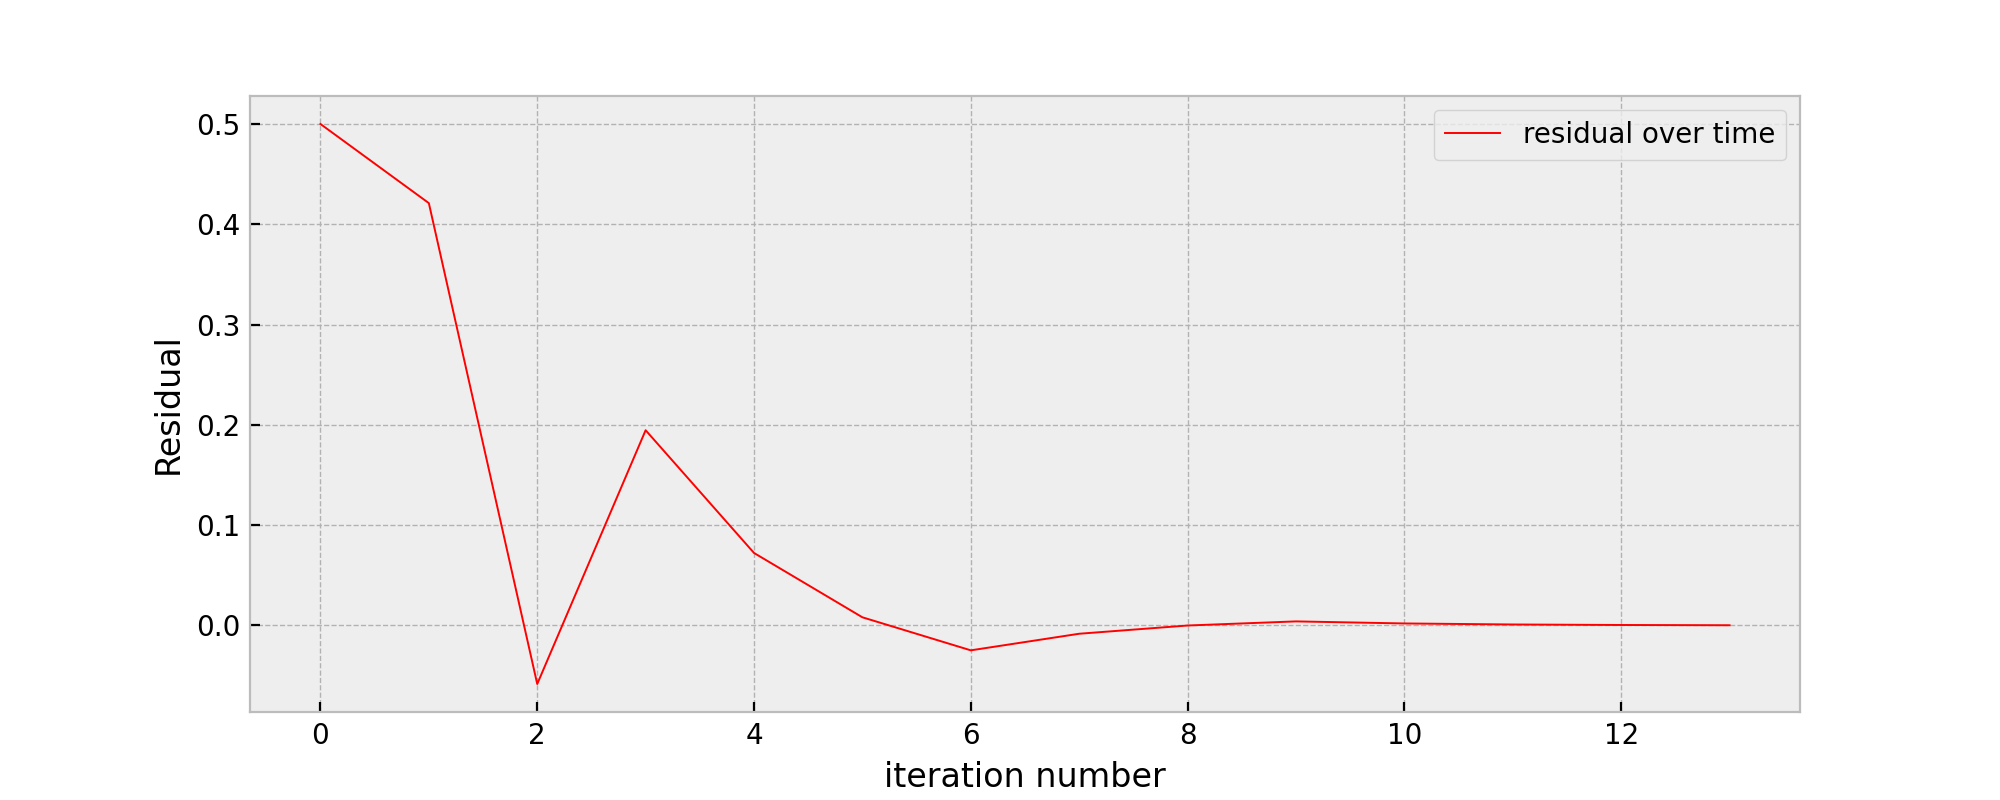

In [3]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.style.use('bmh')

def bisect(u0,guess_to_residual,RK4):
    iteration = []
    residual = []
    
    print(f'|  i  |    u0    |    u1    |     r    |')
    print(f' --------------------------------------')
    r1 = 0
    r1g = 0
    itt =0
    r0 = guess_to_residual(u0,RK4)
    if r0 > 0:
        while r1 >= 0 and r1g < 1000:
            u1 = 1/random.randint(1,1000)
            r1 = guess_to_residual(u1,RK4)
            r1g += 1
    elif r0 < 0:
        while r1 <= 0 and r1g < 1000:
            u1 = 1/random.randint(1,1000)
            r1 = guess_to_residual(u1,RK4)
            r1g += 1
        ll,gg = r0,u0
        r0,u0 = r1,u1
        r1,u1 = ll,gg  
    r = 0.5
    residual.append(r)
    print(f'|  {itt}  |  {round(u0,4)}  |  {round(u1,4)}  | {round(r,4)} |')
    print(f' --------------------------------------')
    
    while abs(r) > 10**(-4) and itt < 100:
        unew = (u1+u0)/2
        r = guess_to_residual(unew,RK4)
        residual.append(r)
        if r < 0:
            u1 = unew
        elif r >= 0:
            u0 = unew
        itt += 1
        iteration.append(itt)
        if (itt % 2) == 0:
            print(f'|  {itt}  |  {round(u0,6)}  |  {round(u1,6)}  | {round(r,6)} |')
            print(f' --------------------------------------')
    print(round(unew,6))
    
    x_plot = np.arange(len(iteration)+1)
    plt.figure(figsize=(10,4))
    plt.ylabel('Residual')
    plt.xlabel('iteration number')
    plt.plot(x_plot, residual, color='r', label="residual over time", linewidth='0.7')
    plt.legend()
    plt.show()
    return
    
bisect(1,guess_to_residual,RK4)

---
#### Plotting a data stream

We have a data stream but what is this a stream of? We are modeling a real system here, so these values represent something happening in real life. The following are multiple plots of our values, namely [𝑥,𝑦,𝑧], as they move across time. What does this show?

First, three time-series plots to show 𝑥, 𝑦, and 𝑧 as they move across time.

Now that we got the best possible value for z, we can solve the initial value problem one more time to record the results.

The time-scale is defined above. We want to move the initial conditions across time, so a single loop is used. This is because this is an **iterative method**. Slicing is used to print the first and last four values of the data stream.

<IPython.core.display.Javascript object>


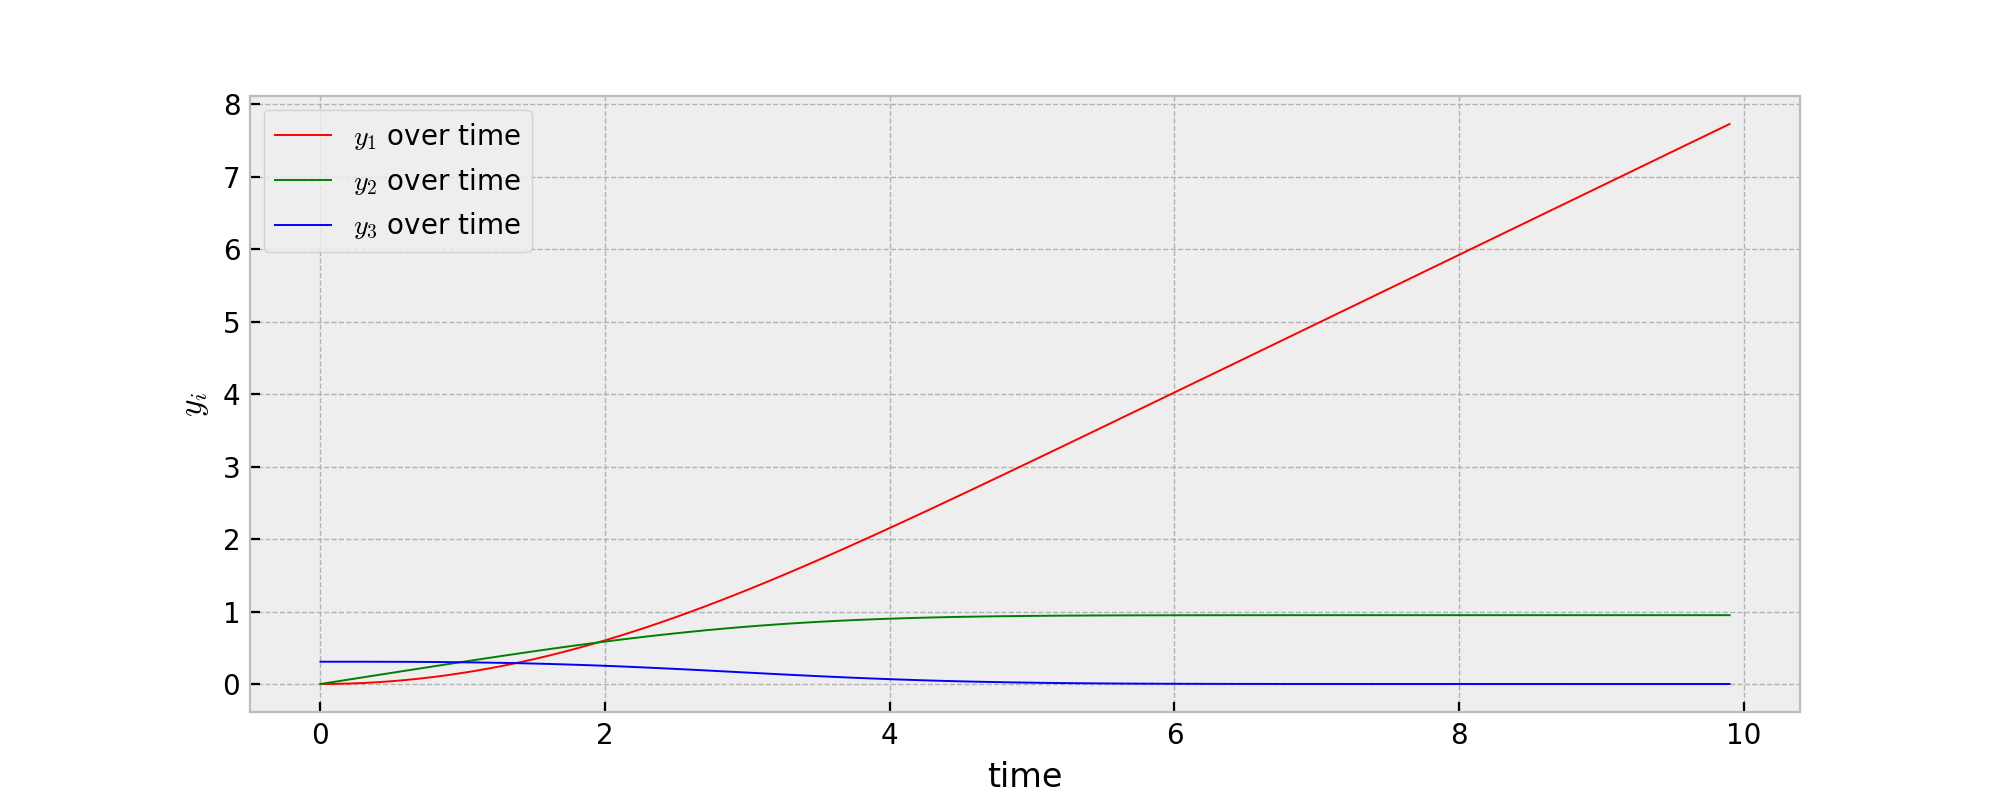

In [4]:
t0 = 0.
dt = 0.1
tmax = 10.
vector_t = np.arange(t0, tmax, dt)
n = len(vector_t)
rk4_velocity_data = np.zeros((n, 3)) # initial conditions
rk4_velocity_data[0, 0] = 0
rk4_velocity_data[0, 1] = 0
rk4_velocity_data[0, 2] = 0.307467
for i in range(n-1): 
    rk4_velocity_data[i+1, :] = RK4(vector_t[i], rk4_velocity_data[i, 0], rk4_velocity_data[i, 1], rk4_velocity_data[i, 2], dt)

plt.figure(figsize=(10,4))
plt.ylabel('$y_i$')
plt.xlabel('time')
plt.plot(vector_t[:n], rk4_velocity_data[:n,0], color='r', label="$y_1$ over time", linewidth='0.7')
plt.plot(vector_t[:n], rk4_velocity_data[:n,1], color='g', label="$y_2$ over time", linewidth='0.7')
plt.plot(vector_t[:n], rk4_velocity_data[:n,2], color='b', label="$y_3$ over time", linewidth='0.7')
plt.legend()
plt.show()

---
#### Coupled Data
here we find the velocity and temp at the same time...


In [5]:
def RK4_temp(t, y1, y2, y3, y4, y5, dt):
    def equation_1(t, y1, y2, y3, y4, y5):
        return y2
    def equation_2(t, y1, y2, y3, y4, y5):
        return y3
    def equation_3(t, y1, y2, y3, y4, y5):
        return (-1/2)*(y1*y3)
    def equation_4(t, y1, y2, y3, y4, y5):
        return y5
    def equation_5(t, y1, y2, y3, y4, y5):
        return (-1/2)*eta*(y1*y5)
    
    k1 = np.array([0., 0., 0., 0., 0.])
    k2 = np.array([0., 0., 0., 0., 0.])
    k3 = np.array([0., 0., 0., 0., 0.])
    k4 = np.array([0., 0., 0., 0., 0.])

    k1[0] = dt*equation_1(t, y1, y2, y3, y4, y5)
    k1[1] = dt*equation_2(t, y1, y2, y3, y4, y5)
    k1[2] = dt*equation_3(t, y1, y2, y3, y4, y5)
    k1[3] = dt*equation_4(t, y1, y2, y3, y4, y5)
    k1[4] = dt*equation_5(t, y1, y2, y3, y4, y5)

    k2[0] = dt*equation_1(t + dt/2., y1 + k1[0]/2., y2 + k1[1]/2., y3 + k1[2]/2., y4 + k1[2]/2., y5 + k1[2]/2.)
    k2[1] = dt*equation_2(t + dt/2., y1 + k1[0]/2., y2 + k1[1]/2., y3 + k1[2]/2., y4 + k1[2]/2., y5 + k1[2]/2.)
    k2[2] = dt*equation_3(t + dt/2., y1 + k1[0]/2., y2 + k1[1]/2., y3 + k1[2]/2., y4 + k1[2]/2., y5 + k1[2]/2.)
    k2[3] = dt*equation_4(t + dt/2., y1 + k1[0]/2., y2 + k1[1]/2., y3 + k1[2]/2., y4 + k1[2]/2., y5 + k1[2]/2.)
    k2[4] = dt*equation_5(t + dt/2., y1 + k1[0]/2., y2 + k1[1]/2., y3 + k1[2]/2., y4 + k1[2]/2., y5 + k1[2]/2.)

    k3[0] = dt*equation_1(t + dt/2., y1 + k2[0]/2., y2 + k2[1]/2., y3 + k2[2]/2., y4 + k2[2]/2., y5 + k2[2]/2.)
    k3[1] = dt*equation_2(t + dt/2., y1 + k2[0]/2., y2 + k2[1]/2., y3 + k2[2]/2., y4 + k2[2]/2., y5 + k2[2]/2.)
    k3[2] = dt*equation_3(t + dt/2., y1 + k2[0]/2., y2 + k2[1]/2., y3 + k2[2]/2., y4 + k2[2]/2., y5 + k2[2]/2.)
    k3[3] = dt*equation_4(t + dt/2., y1 + k2[0]/2., y2 + k2[1]/2., y3 + k2[2]/2., y4 + k2[2]/2., y5 + k2[2]/2.)
    k3[4] = dt*equation_5(t + dt/2., y1 + k2[0]/2., y2 + k2[1]/2., y3 + k2[2]/2., y4 + k2[2]/2., y5 + k2[2]/2.)

    k4[0] = dt*equation_1(t + dt, y1 + k3[0], y2 + k3[1], y3 + k3[2], y4 + k3[2], y5 + k3[2])
    k4[1] = dt*equation_2(t + dt, y1 + k3[0], y2 + k3[1], y3 + k3[2], y4 + k3[2], y5 + k3[2])
    k4[2] = dt*equation_3(t + dt, y1 + k3[0], y2 + k3[1], y3 + k3[2], y4 + k3[2], y5 + k3[2])
    k4[3] = dt*equation_4(t + dt, y1 + k3[0], y2 + k3[1], y3 + k3[2], y4 + k3[2], y5 + k3[2])
    k4[4] = dt*equation_5(t + dt, y1 + k3[0], y2 + k3[1], y3 + k3[2], y4 + k3[2], y5 + k3[2])

    y1 = y1 + (1./6.)*(k1[0] + 2.*k2[0] + 2.*k3[0] + k4[0])
    y2 = y2 + (1./6.)*(k1[1] + 2.*k2[1] + 2.*k3[1] + k4[1])
    y3 = y3 + (1./6.)*(k1[2] + 2.*k2[2] + 2.*k3[2] + k4[2])
    y4 = y4 + (1./6.)*(k1[3] + 2.*k2[3] + 2.*k3[3] + k4[3])
    y5 = y5 + (1./6.)*(k1[4] + 2.*k2[4] + 2.*k3[4] + k4[4])
    
    return np.array([y1, y2, y3, y4, y5])

def guess_to_residual_G(u_G,RK4_temp):
    t0 = 0.
    dt = 0.1
    tmax = 10.
    vector_t = np.arange(t0, tmax, dt)
    n = len(vector_t)
    
    rk4_temp_data = np.zeros((n, 5))
    rk4_temp_data[0, 0] = 0
    rk4_temp_data[0, 1] = 0
    rk4_temp_data[0, 2] = 0.307467
    rk4_temp_data[0, 3] = 1
    rk4_temp_data[0, 4] = u_G
    
    for i in range(n-1): 
        rk4_temp_data[i+1, :] = RK4_temp(vector_t[i], rk4_temp_data[i,0], rk4_temp_data[i,1], rk4_temp_data[i,2], rk4_temp_data[i,3], rk4_temp_data[i,4],  dt)

    y = rk4_temp_data[len(rk4_temp_data) - 1]
    r = y[3] - 0.95
    return r

|  i  |    u0    |    u1    |     r    |
 --------------------------------------
|  0  |  0.5  |  0.0119  | 0.5 |
 --------------------------------------
|  2  |  0.133929  |  0.011905  | 0.288134 |
 --------------------------------------
|  4  |  0.042411  |  0.011905  | 0.123557 |
 --------------------------------------
|  6  |  0.019531  |  0.011905  | 0.082413 |
 --------------------------------------
|  8  |  0.013811  |  0.011905  | 0.072127 |
 --------------------------------------
|  10  |  0.012381  |  0.011905  | 0.069555 |
 --------------------------------------
|  12  |  0.012024  |  0.011905  | 0.068912 |
 --------------------------------------
|  14  |  0.011935  |  0.011905  | 0.068752 |
 --------------------------------------
|  16  |  0.011912  |  0.011905  | 0.068711 |
 --------------------------------------
|  18  |  0.011907  |  0.011905  | 0.068701 |
 --------------------------------------
|  20  |  0.011905  |  0.011905  | 0.068699 |
 -----------------------------

<IPython.core.display.Javascript object>


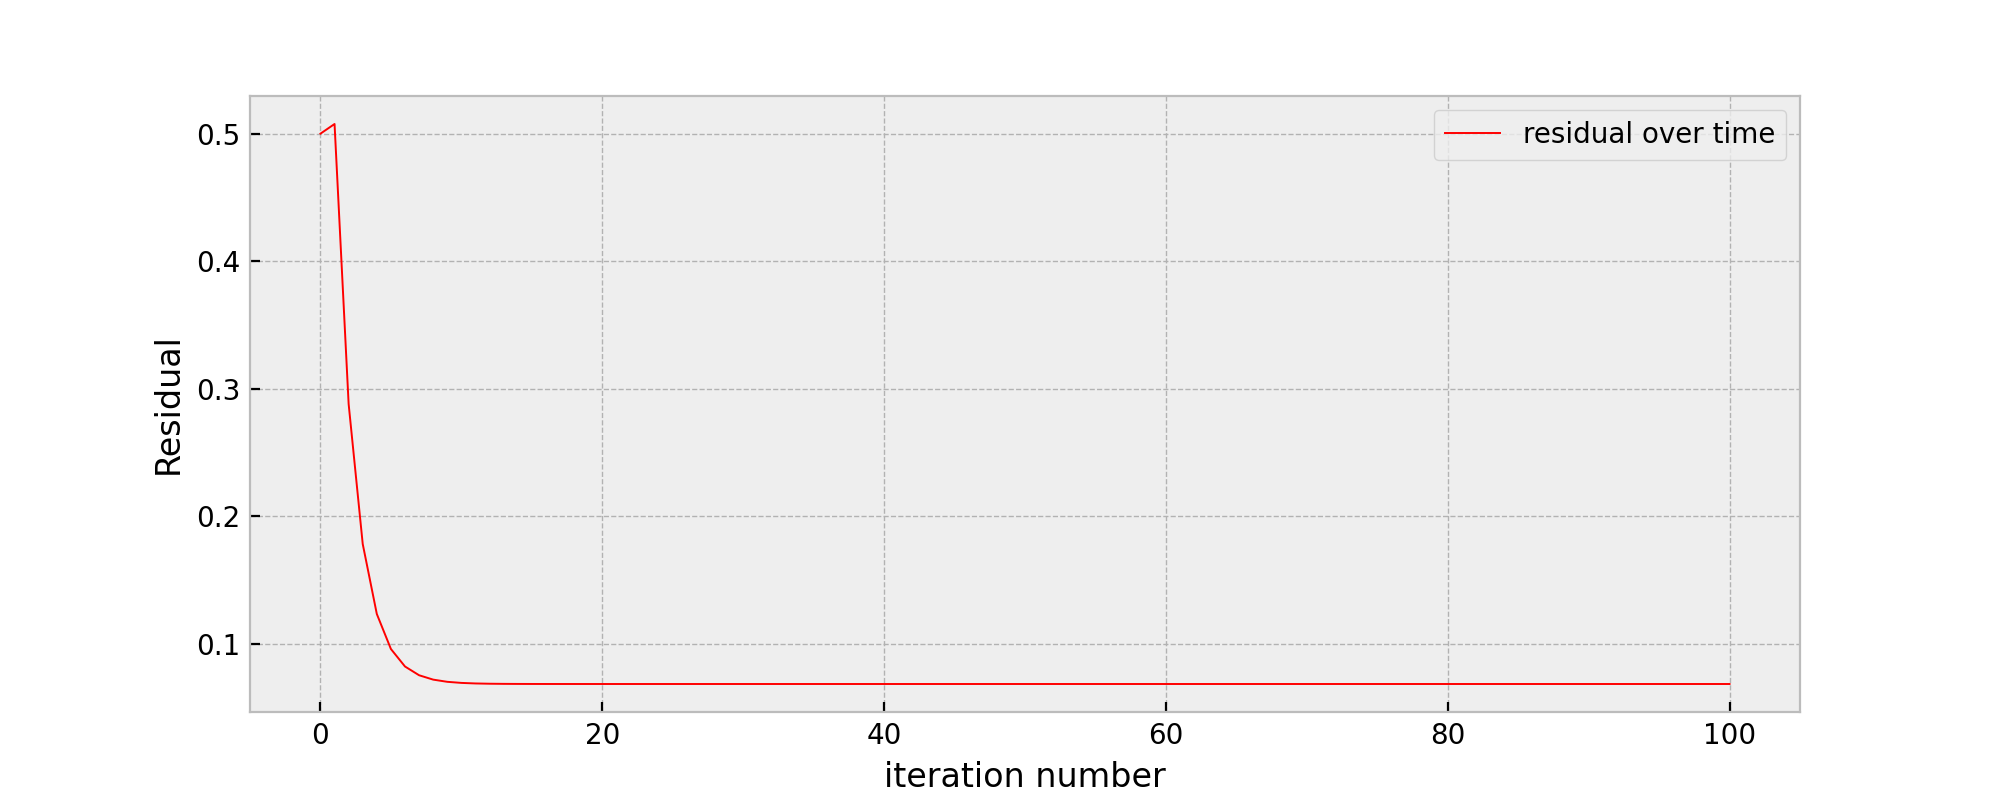

In [6]:
eta = 5
bisect(0.5,guess_to_residual_G,RK4_temp)
    

<IPython.core.display.Javascript object>


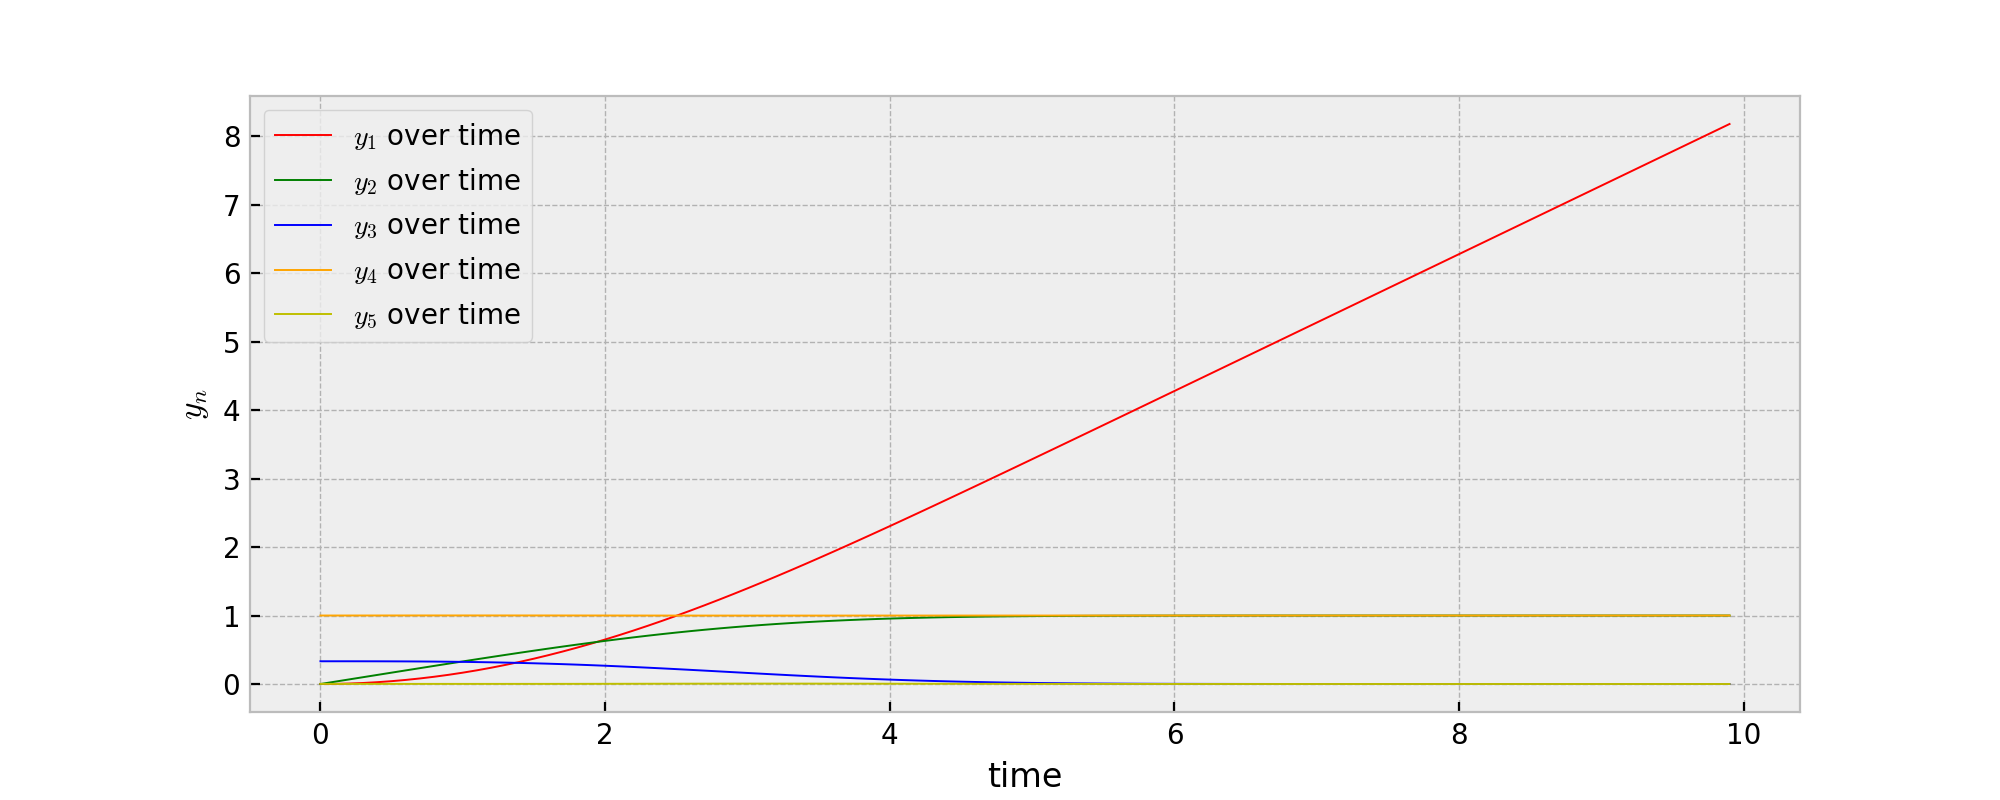

In [7]:
t0 = 0.
dt = 0.1
tmax = 10.
vector_t = np.arange(t0,tmax,dt)
n = len(vector_t)
rk4_data = np.zeros((n,5))

rk4_data[0, 0] = 0
rk4_data[0, 1] = 0
rk4_data[0, 2] = 0.332057
rk4_data[0, 3] = 1
rk4_data[0, 4] = 0.001667
for i in range(n-1): 
        rk4_data[i+1,:] = RK4_temp(vector_t[i], rk4_data[i, 0], rk4_data[i, 1], rk4_data[i, 2], rk4_data[i, 3], rk4_data[i, 4],  dt)
    
plt.figure(figsize=(10,4))
plt.ylabel('$y_n$')
plt.xlabel('time')
plt.plot(vector_t[:n], rk4_data[:n,0], color='r', label="$y_1$ over time", linewidth='0.7')
plt.plot(vector_t[:n], rk4_data[:n,1], color='g', label="$y_2$ over time", linewidth='0.7')
plt.plot(vector_t[:n], rk4_data[:n,2], color='b', label="$y_3$ over time", linewidth='0.7')
plt.plot(vector_t[:n], rk4_data[:n,3], color='orange', label="$y_4$ over time", linewidth='0.7')
plt.plot(vector_t[:n], rk4_data[:n,4], color='y', label="$y_5$ over time", linewidth='0.7')
plt.legend()
plt.show()

In [9]:
print("First and last 5 terms: \n",rk4_data[:5,:])
print("...")
print(rk4_data[n-5:,:])

First and last 5 terms: 
 [[0.         0.         0.332057   1.         0.001667  ]
 [0.00166029 0.03320547 0.33204781 1.00016647 0.00166677]
 [0.006641   0.06640772 0.3319835  1.00033062 0.00166519]
 [0.01494146 0.0995985  0.33180901 1.00048956 0.00166104]
 [0.02655988 0.13276403 0.33146951 1.00064029 0.00165341]]
...
[[7.77920649e+00 9.99999292e-01 6.29230986e-08 9.99998661e-01
  1.29619961e-08]
 [7.87920642e+00 9.99999298e-01 4.25448684e-08 9.99998661e-01
  8.85979185e-09]
 [7.97920635e+00 9.99999301e-01 2.86230579e-08 9.99998661e-01
  6.02472030e-09]
 [8.07920628e+00 9.99999304e-01 1.91609403e-08 9.99998661e-01
  4.07581102e-09]
 [8.17920621e+00 9.99999305e-01 1.27629111e-08 9.99998661e-01
  2.74319665e-09]]
